In [71]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats  as stats

Read in the CSV file from the book's [web site](https://ben-lambert.com/a-students-guide-to-bayesian-statistics/):

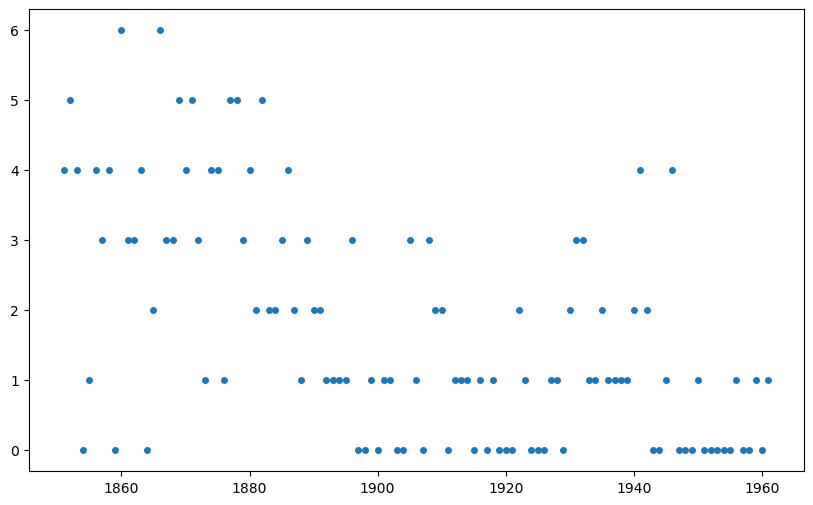

In [3]:
data = np.loadtxt("gibbs_coal.csv", delimiter=",",skiprows=1)
plt.figure(figsize=(10, 6))
plt.plot(data[:, 0], data[:, 1], 'o', markersize=4, label='Data')

This is a 'changepoiont' type problem. We model this by assuming there was a rate of coal mining disasters before some year where some policy change caused the rate to change.

We assume a Poission distribution with rate parameter $\lambda_1$ if $t<= n$ and $\lambda_2$ if $t>n$. The model is then given by:
$$
\begin{align*}
D_t \sim \begin{cases}
 \text{Poisson}(\lambda_1) & \text{if } t \leq n \\
 \text{Poisson}(\lambda_2) & \text{if } t > n
\end{cases}
\end{align*}
$$

We aim to determine the posterior for $n$, $\lambda_1$, and $\lambda_2$ given the observed data $D_t$.
We will use a conjugate prior for the Poisson distribution, which is a gamma distribution. $\Gamma(a, b)$  

From this we can write down the full unnormalized posterior (noting that the prior on n is uniform so drops out in the unnormalized posterior):
$$
\begin{align*}
p(n, \lambda_1, \lambda_2 | D) &\propto p(D | n, \lambda_1, \lambda_2) p(n) p(\lambda_1) p(\lambda_2) \\
&= \prod_{t=1}^n \frac{\lambda_1^{D_t} e^{-\lambda_1}}{D_t!} \prod_{t=n+1}^{N} \frac{\lambda_2^{D_t} e^{-\lambda_2}}{D_t!} \Gamma(\lambda_1; a, b) \Gamma(\lambda_2; a, b) \\    
\end{align*}
$$

Expanding the gamma distribution and dropping normalization constants, we have:

$$
\begin{align*}
p(n, \lambda_1, \lambda_2 | D) &\propto \prod_{t=1}^n \lambda_1^{D_t} e^{-\lambda_1}  \prod_{t=n+1}^{N}  \lambda_2^{D_t} e^{-\lambda_2} \Gamma(\lambda_1; a, b) \Gamma(\lambda_2; a, b) \\
&= \prod_{t=1}^n \lambda_1^{D_t} e^{-\lambda_1} \prod_{t=n+1}^{N} \lambda_2^{D_t} e^{-\lambda_2}  \lambda_1^{a-1} e^{-b\lambda_1}  \lambda_2^{a-1} e^{-b\lambda_2} \\
&= \lambda_1^{\sum_{t=1}^n D_t + a - 1} e^{-(b+n)\lambda_1} \lambda_2^{\sum_{t=n+1}^{N} D_t + a - 1} e^{-(b+(N-n)\lambda_2} \\
&= \Gamma(\lambda_1; \sum_{t=1}^n D_t + a, b+n) \times \Gamma(\lambda_2; \sum_{t=n+1}^{N} D_t + a, b+(N-n)) \\
\end{align*}


From this we can read off the conditional posterior distributions for $\lambda_1$ and $\lambda_2$, but we need to also determine the conditional posterior for $n$.  We can proceed by first gathering all the terms that only depend on $n$:

$$
\begin{align*}
p(n | D, \lambda_1, \lambda_2) &\propto  \lambda_1^{\sum_{t=1}^n D_t} e^{-n \lambda_1} \lambda_2^{\sum_{t=n+1}^{N} D_t} e^{-(N-n) \lambda_2} \\
\end{align*}
$$

We can normalize this by summing over all possible values of $n$ when we do this in the Gibbs sampler

From this we define three seperate samplers:

In [39]:
def sample_n(lambda1,lambda2,counts):
    """
    Sample a point from the distribution for n given fixed lambda1 and lambda2
    Note that n ranges from 1 to N, so we have to be careful about indexing
    """
    # TODO  : check that i am not doing a off by one error.
    # Sample from the Poisson distribution
    # table of un-normalized probabilities
    N = len(counts)

    un_norm_prob = np.zeros(N)
    for n in range(N):
        sum_D1 = np.sum(counts[:n+1])
        sum_D2 = np.sum(counts[n+1:])
        un_norm_prob[n] = (lambda1**sum_D1) * np.exp(-(n+1)*lambda1)*\
                          (lambda2**sum_D2) * np.exp(-(N-n-1)*lambda2)
    # Normalize the probabilities
    norm_prob = un_norm_prob / np.sum(un_norm_prob)
    # Sample from the normalized probabilities
    sampled_n = np.random.choice(np.arange(1, N+1), p=norm_prob)
    #eturn norm_prob
    return sampled_n



For lambda, we just use the corresponding gamma distribution.  I am sure this is more verbose then necessary.

In [ ]:
def sample_lambda_1(counts, n,a,b):
    """
    Sample a point from the distribution for lambda1 given fixed n
    """
    alpha = np.sum(counts[:n]) + a
    beta = n + b
    # Sample from the gamma distribution
    lambda1 = np.random.gamma(alpha, 1/beta)
    return lambda1

def sample_lambda_2(counts, n,a,b):
    """
    Sample a point from the distribution for lambda2 given fixed n
    """
    alpha = np.sum(counts[n:]) + a
    beta = len(data) - n + b
    # Sample from the gamma distribution
    lambda2 = np.random.gamma(alpha, 1/beta)
    return lambda2



Finally we are ready to implement the Gibbs sampler.  Again I do this in a straighforward albeit inefficient way, but for such a simple model it will not matter.

In [59]:
def gibbs_sampling(counts, a, b, num_samples):
    """
    Perform Gibbs sampling for the given data
    """
    # Initialize the parameters
    N = len(counts)
    lambda1 = np.random.gamma(a, 1/b)
    lambda2 = np.random.gamma(a, 1/b)
    n = np.random.randint(1, N+1)

    samples = []

    # random order of sampling
    order = ["lambda1", "lambda2", "n"]

    for _ in range(num_samples):

        np.random.shuffle(order)
        for param in order:
            if param == "lambda1":
                # Sample lambda1 given n
                lambda1 = sample_lambda_1(counts, n, a, b)
            elif param == "lambda2":
                # Sample lambda2 given n
                lambda2 = sample_lambda_2(counts, n, a, b)
            elif param == "n":
                # Sample n given lambda1 and lambda2
                n = sample_n(lambda1, lambda2, counts)

        samples.append((lambda1, lambda2,n))

    return np.array(samples)

A reasonable prior Gamms is $\Gamma(1,0.1)$.  This is something that would need to be thought about more in practice, with prior sample check

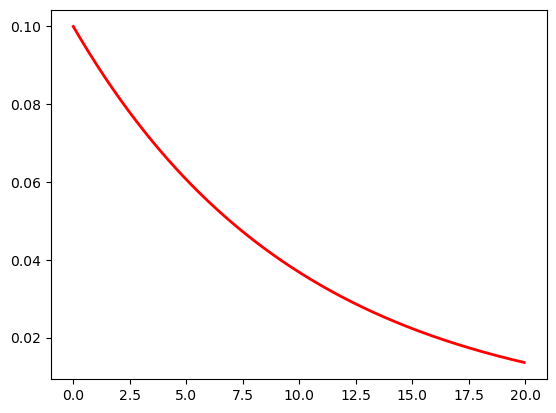

In [123]:
c =np.arange(0, 20, 0.05)
p = stats.gamma.pdf(c, 1.0, scale = 1/0.1)
plt.plot(c, p, 'r-', lw=2, label='Gamma PDF')

In [88]:
samples = gibbs_sampling(data[:, 1], 1, .5, 2000)

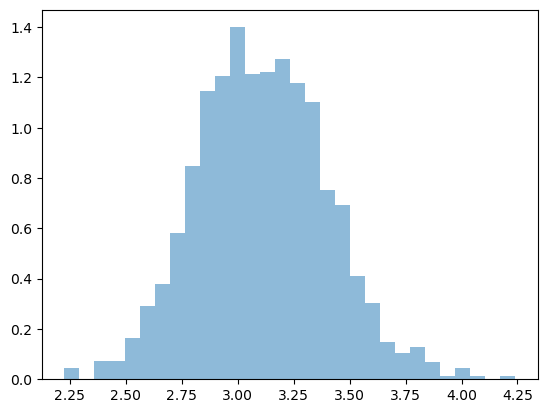

In [89]:
plt.hist(samples[:,0], bins=30, density=True, alpha=0.5);

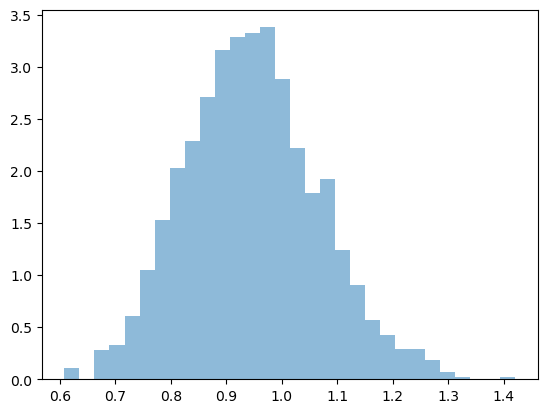

In [90]:
plt.hist(samples[:,1], bins=30, density=True, alpha=0.5);

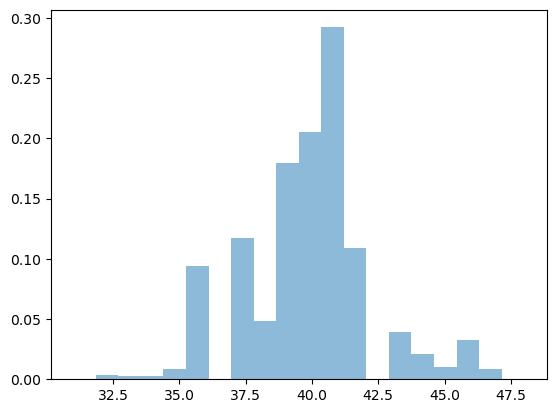

In [93]:
plt.hist(samples[:,2], bins=20, density=True, alpha=0.5);

In [124]:
np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:,2])
                                                

(3.1095628837056815, 0.9459781167019777, 39.9225)

In [125]:
np.mean(samples[:,2]) + data[0,0]

1890.9225

1890 seems reasonable

## Simulated data based on the model

This function takes in a lambda_1, lambda_2, n and N and returns a vector of length N with a single posterior predictive sample.

In [100]:
# simulation
def sample_from_posterior_pred(lambda1, lambda2, n, N):
    """
    Sample from the posterior predictive distribution
    """
    samples = np.zeros(N)
    for i in range(N):
        # Sample from the Poisson distribution
        if i < n:
            samples[i] = np.random.poisson(lambda1)
        else:
            samples[i] = np.random.poisson(lambda2)
             
    return samples



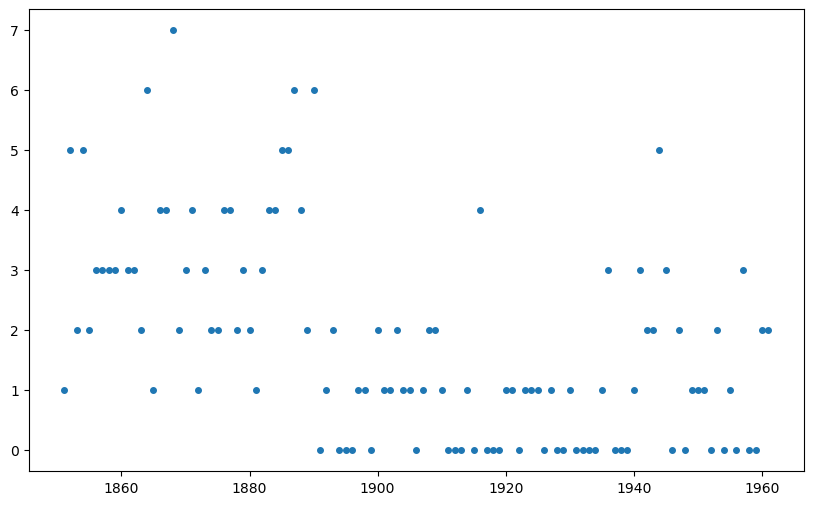

In [103]:
fake_data = sample_from_posterior_pred(3.1,0.94, 40, len(data[:,1]))
plt.figure(figsize=(10, 6))
#plt.plot(data[:, 0], data[:, 1], 'o', markersize=4, label='Data')
plt.plot(data[:, 0], fake_data, 'o', markersize=4, label='Fake Data')

Looks reassuringly like the original data.

## Next: Plot posterior rates 

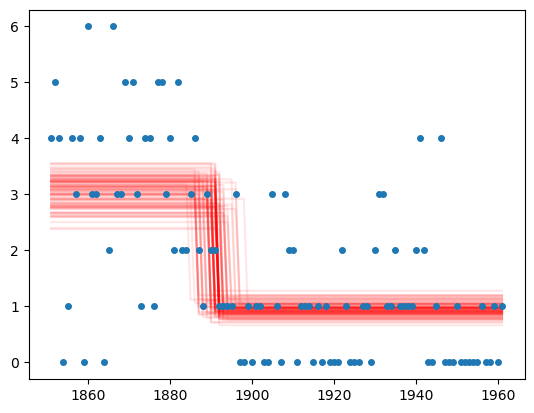

In [122]:
def plot_posterior_rate(lambda1, lambda2, n, N,**kwargs):
    """
    Plot the posterior predictive distribution
    """
    i = np.arange( N)
    rate = np.where(i < n, lambda1, lambda2)
    plt.plot(i+data[0,0], rate,**kwargs)

for sample in samples[:100,:]:
    lambda1, lambda2, n = sample
    plot_posterior_rate(lambda1, lambda2, n, len(data[:,1]), color='red', alpha=0.1)


plt.plot(data[:, 0], data[:, 1], 'o', markersize=4, label='Data')